# Marine Heatwaves 
This notebook examines global satellite sea surface temperature (SST) in the  NOAA  Optimum  Interpolation  Sea  Surface Temperature (OISST) dataset. The Marine Heatwave (MHW) definition of Hobday et al. (found here: https://tos.org/oceanography/assets/docs/31-2_hobday.pdf) is implemented using the the marineHeatWaves module as outlined here: https://github.com/ecjoliver/marineHeatWaves/blob/master/docs/example_synthetic.ipynb.

For more information on the OISST dataset:
https://www.ncdc.noaa.gov/oisst


The files can be found at: 
https://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/noaa.oisst.v2.highres/catalog.html

https://www.ncei.noaa.gov/thredds/catalog/OisstBase/NetCDF/AVHRR/catalog.html

https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html

https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/access/avhrr-only/201006/


https://www.ncei.noaa.gov/thredds/dodsC/ncFC/fc-oisst-daily-avhrr-only-dly/files/198201/avhrr-only-v2.19820101.nc.ascii?


http://www.marineheatwaves.org/tracker.html

In [48]:
%matplotlib inline
# Load required modules
import numpy as np
import xarray as xr
import scipy.stats as stats
from urllib.request import Request, urlopen
from matplotlib import pyplot as plt
import time
from datetime import date, timedelta
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from calendar import monthrange
# Load marineHeatWaves definition module.
# NOTE: marineHeatWaves.py must be saved in the same folder as this notebook,
# which can be copied from https://github.com/ecjoliver/marineHeatWaves/blob/master/marineHeatWaves.py
import marineHeatWaves as mhw

import yaml # Don't worry about the yaml warming.

In [49]:
# Enter the latitude and longitude of the csv file you downloaded:
latitude = -28.875
longitude = 112.875

mhws = pd.read_csv('event_lon_{}_lat_{}.csv'.format(longitude, latitude), parse_dates=[4, 5, 6])
clim = pd.read_csv('clim_lon_{}_lat_{}.csv'.format(longitude, latitude))

### Print out the first few lines of each file:

In [60]:
clim.head() # To show all the data: remove ".head()".

lon     lat  doy   seas  thresh
0  112.875 -28.875    1  22.04   23.38
1  112.875 -28.875    2  22.07   23.41
2  112.875 -28.875    3  22.10   23.44
3  112.875 -28.875    4  22.12   23.47
4  112.875 -28.875    5  22.15   23.50

In [59]:
mhws.head()

lon     lat  event_no  duration date_start  date_peak   date_end  \
0  112.875 -28.875         1         6 1982-08-07 1982-08-10 1982-08-12   
1  112.875 -28.875         2         5 1983-01-16 1983-01-18 1983-01-20   
2  112.875 -28.875         3        11 1983-06-06 1983-06-12 1983-06-16   
3  112.875 -28.875         4        15 1984-06-28 1984-07-02 1984-07-12   
4  112.875 -28.875         5         5 1984-07-28 1984-07-31 1984-08-01   

   intensity_mean  intensity_max  intensity_cumulative  
0           1.327           1.47                  7.96  
1           1.608           1.70                  8.04  
2           1.971           2.45                 21.68  
3           1.830           2.12                 27.45  
4           1.288           1.36                  6.44

0    1.47
1    1.70
2    2.45
3    2.12
4    1.36
5    2.41
6    1.81
7    1.51
8    1.87
9    2.30
Name: intensity_max, dtype: float64

At your location, there was the following number of MHW events:

In [128]:
total_mhws = len(mhws.event_no)
print(total_mhws)

67


Lets look at the number of MHWs that fall in each category:

In [129]:
print('Total number of MHWs:', total_mhws)
print('Category I (Moderate):', sum(i < 2 for i in mhws.intensity_mean))
print('Category II (Strong):', sum(2 < i < 3 for i in mhws.intensity_mean))
print('Category III (Severe):', sum(3 < i < 4 for i in mhws.intensity_mean))
print('Category IV (Extreme):', sum(i > 4 for i in mhws.intensity_mean))

Total number of MHWs: 67
Category I (Moderate): 54
Category II (Strong): 12
Category III (Severe): 1
Category IV (Extreme): 0


In [103]:
# Let's look at our time series and find the largest MHW event:
ev = np.argmax(mhws.intensity_max)
print('Maximum intensity: {:.2f}°C'.format(mhws.intensity_max[ev]))
print('Average intensity: {:.2f}°C'.format(mhws.intensity_mean[ev]))
print('Cumulative intensity: {:.1f}°C-days'.format(mhws.intensity_cumulative[ev]))
print('Duration:', mhws.duration[ev], 'days')
print('Start date:', mhws.date_start[ev].strftime("%d %B %Y"))
print('Peak date:', mhws.date_peak[ev].strftime("%d %B %Y"))
print('End date:', mhws.date_end[ev].strftime("%d %B %Y"))

Maximum intensity: 6.13°C
Average intensity: 3.05°C
Cumulative intensity: 323.3°C-days
Duration: 106 days
Start date: 22 December 2010
Peak date: 25 February 2011
End date: 06 April 2011


In [126]:
t = np.arange(mhws.date_start.min().toordinal(), mhws.date_end.max().toordinal() + 1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]

# Marine Heatwave Detection

The marineHeatWaves (mhw) module consists of a number of functions for the detection and characterization of MHWs.

In [125]:
t

array([723764, 723765, 723766, ..., 735900, 735901, 735902])

Generate an array of SST over time at a selected latitude and longitude (e.g. 30&deg;S,113&deg;E off the coast of Western Australia):

In [ ]:
lat = -30.125
lon = 112.875
sst = ds.sst.sel(lat=lat, lon=lon) # Selects the nearest given grid point. , method='nearest'
sst_climo = climo.sst.sel(lat=lat, lon=lon) # Selects the nearest given grid point.
print('SST at: {}° and {}°'.format(sst.lat.item(), sst.lon.item())) # Print the exact location.
sst = sst.values # ".values" converts from xarray to numpy array (which takes a few mins).
sst_climo = sst_climo.values

Alternatively: find the mean SST over an area:

In [ ]:
# # Make sure the lowest number is first (or the largest negative number).
# sst = ds.sst.sel(lat=slice(-32, -26), lon=slice(112, 115))
# sst_climo = climo.sst.sel(lat=slice(-32, -26), lon=slice(112, 115))
# print('SST averaged over: {}° to {}° and {}° to {}°'.format(sst.lat[0].item(), sst.lat[-1].item(), 
#                                                            sst.lon[0].item(), sst.lon[-1].item())) 
# sst = sst.mean(['lat', 'lon']).values # Generate the mean SST over the area.
# sst_climo = sst_climo.mean(['lat', 'lon']).values

In [ ]:
# Generate a list of dates in (year, month, day) format.
dates = ds.time.values.astype('datetime64[s]').tolist()

# Generate an array time values (in simple numbers for the mhw detect module). 
# If you're curious: ordinal means January 1st of 1582 is day 1 and, for example, January 1st 1998 is day 729390.
t = np.arange(dates[0].toordinal(), dates[-1].toordinal() + 1)

In [ ]:
climo_t = np.arange(date(1982, 1, 1).toordinal(), date(1982, 12, 31).toordinal() + 1)

Now, lets use the mhws detection function (detect) that uses an array of time values and the corresponding SST and returns the variable mhws (the detected MHWs) and clim (the mean seasonal cycle and extremes threshold):

In [ ]:
mhws, clim = mhw.detect(t, sst, smoothPercentile=False, climatologyPeriod=[1982, 1982], alternateClimatology=[climo_t, sst_climo]) 

This algorithm has detected the following number of MHW events:

In [ ]:
print(mhws['n_events'])

## MHWs can be categorised by intensity (in &deg;C):

- 1-2: Category I (Moderate)

- 2-3: Category II (Strong)

- 3-4: Category III (Severe)

- 4+: Category IV (Extreme)

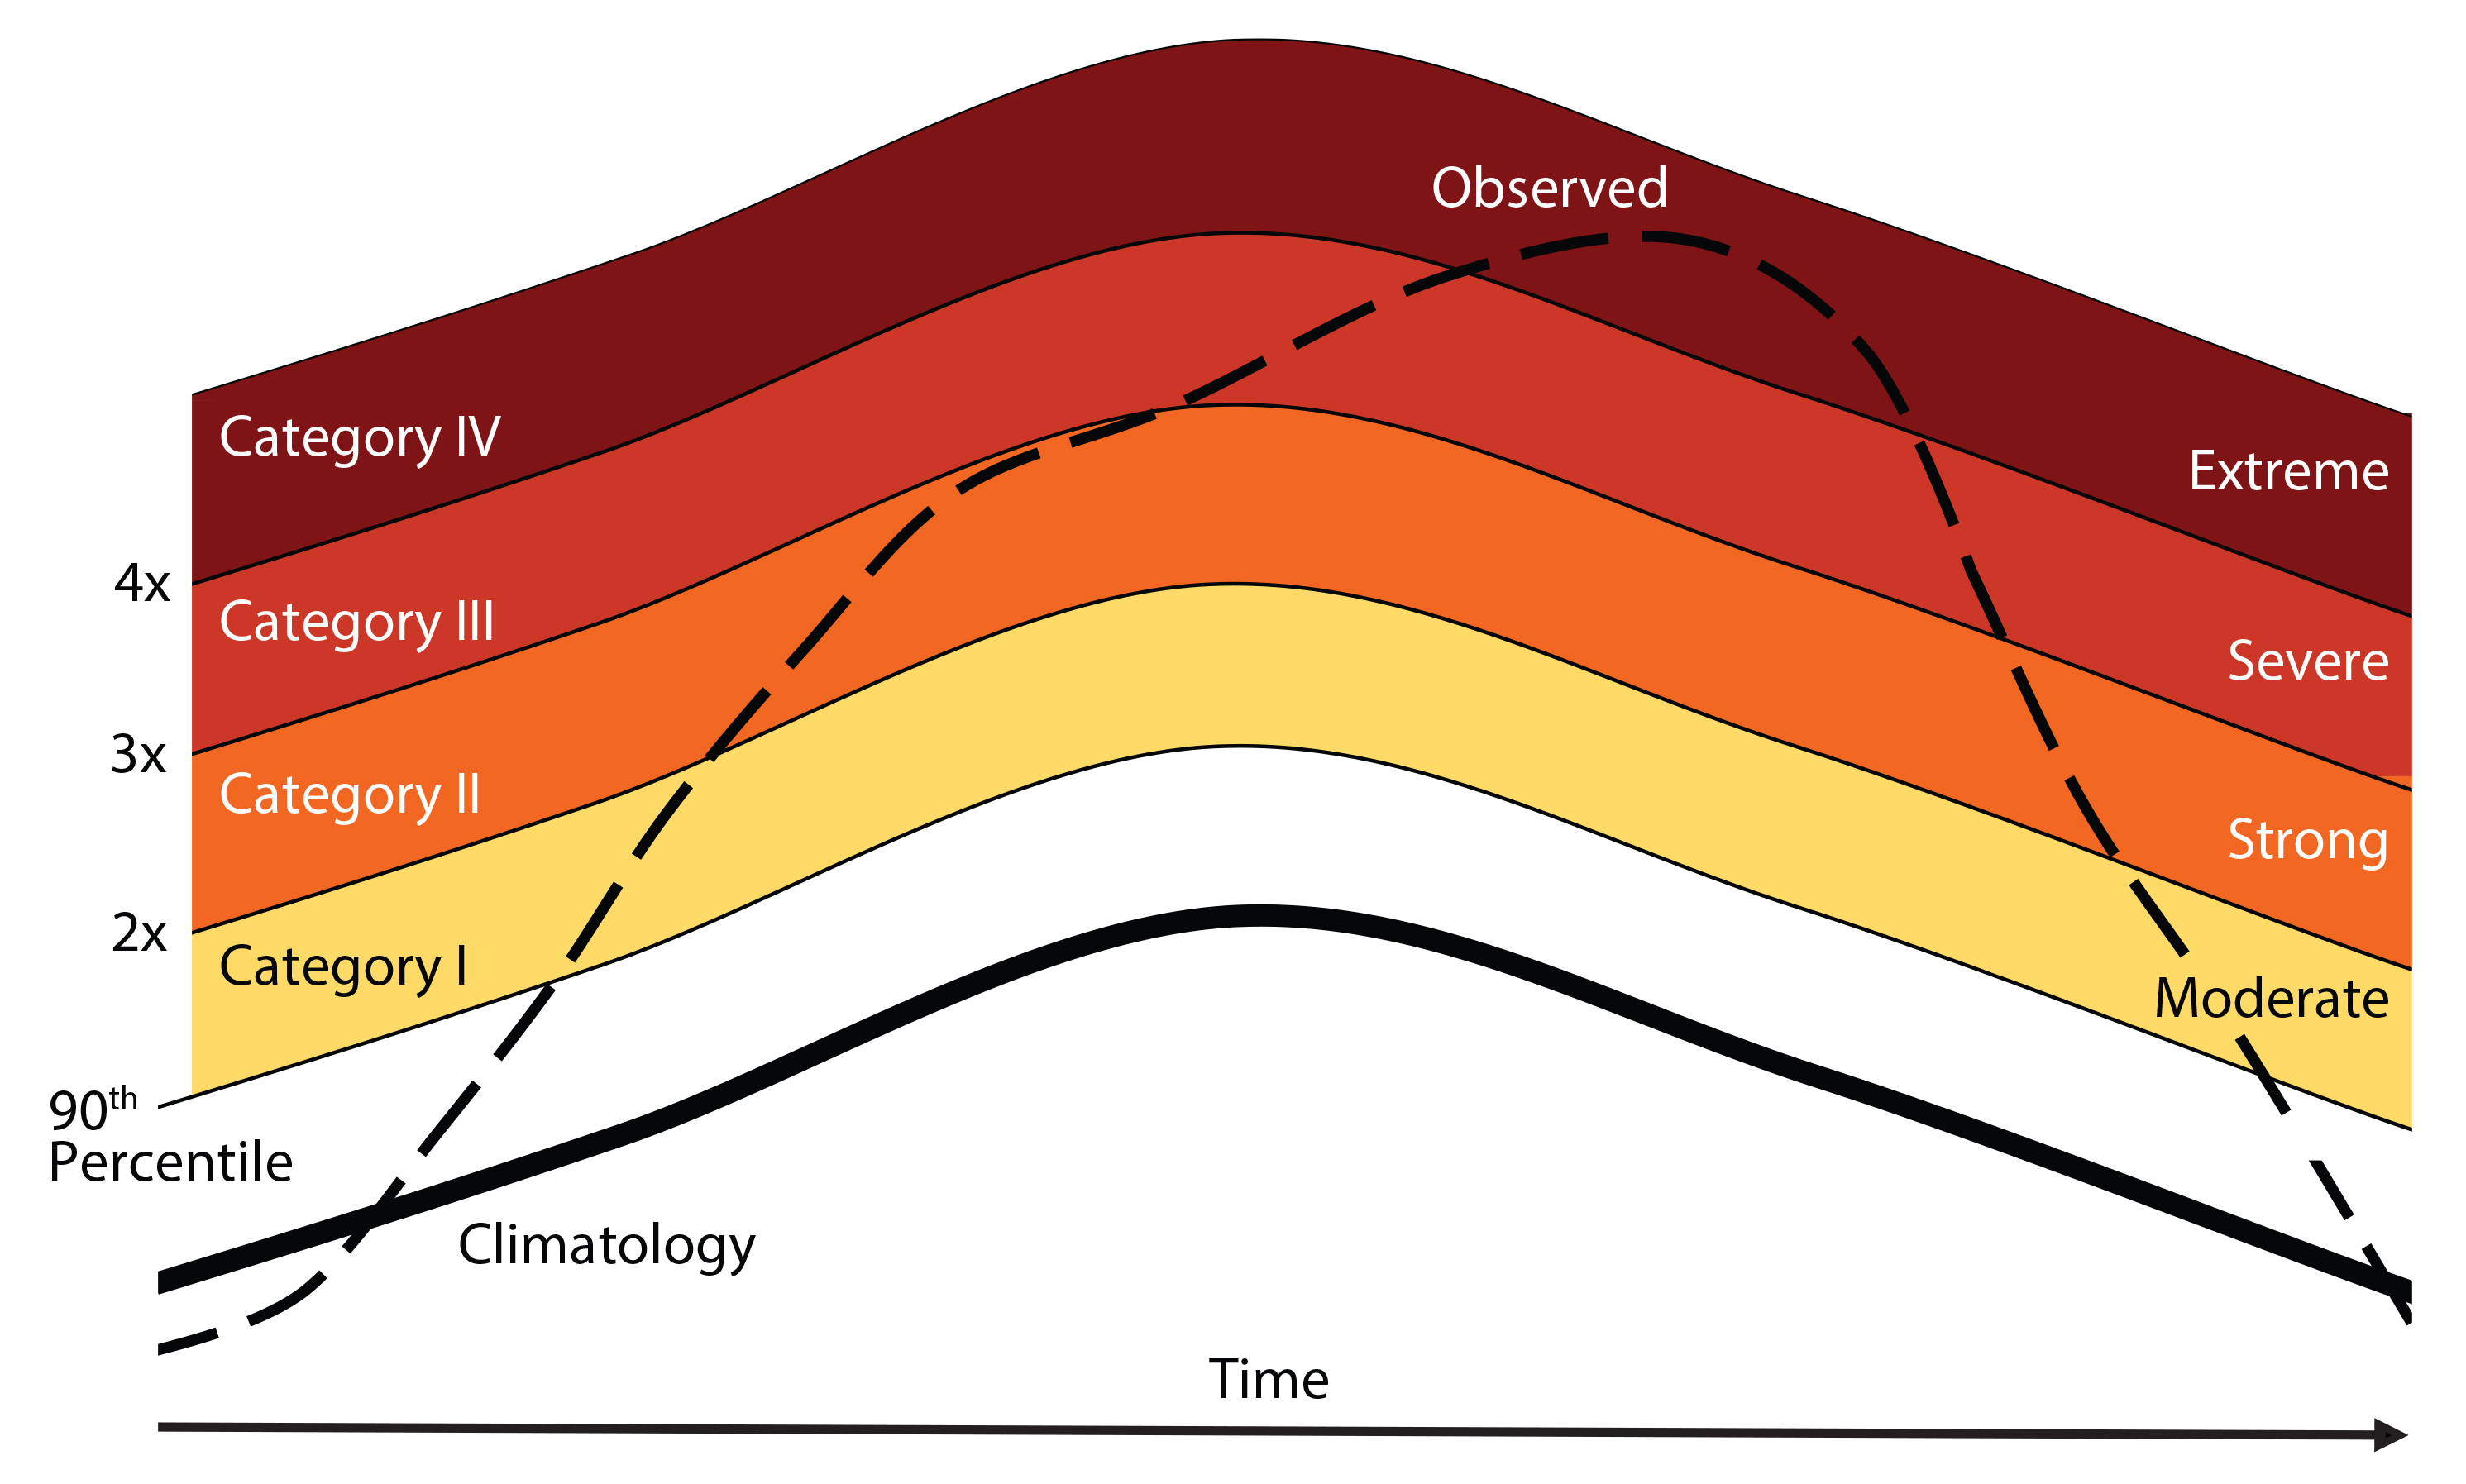 

[Hobday et. al. (2018)](http://tos.org/oceanography/article/categorizing-and-naming-marine-heatwaves)


The last ten events, for example, have the following maximum intensities:

In [ ]:
[print('{:.1f}°C'.format(i)) for i in mhws['intensity_max'][-10::]]

The largest event had the following characteristics:

In [ ]:
ev = np.argmax(mhws['intensity_max']) # Finds the index of the largest event.
print('Maximum intensity: {:.2f}°C'.format(mhws['intensity_max'][ev]))
print('Average intensity: {:.2f}°C'.format(mhws['intensity_mean'][ev]))
print('Cumulative intensity: {:.1f}°C-days'.format(mhws['intensity_cumulative'][ev]))
print('Duration:', mhws['duration'][ev], 'days')
print('Start date:', mhws['date_start'][ev].strftime("%d %B %Y"))
print('Peak date:', mhws['date_peak'][ev].strftime("%d %B %Y"))
print('End date:', mhws['date_end'][ev].strftime("%d %B %Y"))

In [ ]:
# Maximum intensity: 6.02°C
# Average intensity: 2.22°C
# Cumulative intensity: 320.0°C-days
# Duration: 144 days
# Start date: 15 November 2010
# Peak date: 25 February 2011
# End date: 07 April 2011

In [ ]:
# Maximum intensity: 6.27°C
# Average intensity: 2.22°C
# Cumulative intensity: 404.4°C-days
# Duration: 182 days
# Start date: 31 October 2010
# Peak date: 25 February 2011
# End date: 30 April 2011


Lets plot SST over time compared to the climatological mean and MHW threshold:

NameError: name 'sst' is not defined

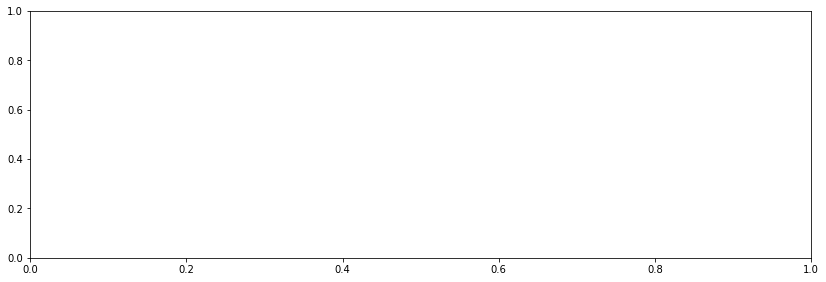

In [127]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)

# Plot SST, seasonal cycle, and threshold.
plt.plot(dates, sst, 'k-')
plt.plot(dates, clim.thresh, 'g-')
plt.plot(dates, clim.seas, 'b-')
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
plt.xlim(t[0], t[-1])
plt.ylim(sst.min() - 0.5, sst.max() + 0.5)
plt.ylabel('SST [°C]')
plt.subplot(2, 1, 2)
# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev - 4, ev + 4, 1):
    t1 = np.where(t == mhws.time_start[ev0])[0][0]
    t2 = np.where(t == mhws.time_end[ev0])[0][0]
    plt.fill_between(dates[t1:t2 + 1], sst[t1:t2 + 1], clim.thresh[t1:t2 + 1], \
                     color=(1, 0.6, 0.5))
# Find indices for MHW of interest and shade accordingly
t1 = np.where(t == mhws.time_start[ev])[0][0]
t2 = np.where(t == mhws.time_end[ev])[0][0]
plt.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim.thresh[t1:t2 + 1], \
                 color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, sst, 'k-', linewidth=2)
plt.plot(dates, clim.thresh, 'g-', linewidth=2)
plt.plot(dates, clim.seas, 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
plt.xlim(mhws.time_start[ev] - 150, mhws.time_end[ev] + 150)
plt.ylim(clim.seas.min() - 1, clim.seas.max() + mhws.intensity_max[ev] + 0.5)
plt.ylabel('SST [°C]')
plt.savefig('SST_timeseries.png')

In [ ]:
plt.figure(figsize=(15, 7))
# Duration
plt.subplot(2, 2, 1)
evMax = np.argmax(mhws['duration'])
plt.bar(range(mhws['n_events']), mhws['duration'], width=0.6, \
        color=(0.7, 0.7, 0.7))
plt.bar(evMax, mhws['duration'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['duration'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.ylabel('[days]')
plt.title('Duration')
# Maximum intensity
plt.subplot(2,2,2)
evMax = np.argmax(mhws['intensity_max'])
plt.bar(range(mhws['n_events']), mhws['intensity_max'], width=0.6, \
        color=(0.7, 0.7, 0.7))
plt.bar(evMax, mhws['intensity_max'][evMax], width=0.6, color=(1, 0.5, 0.5))
plt.bar(ev, mhws['intensity_max'][ev], width=0.6, edgecolor=(1, 0., 0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.ylabel('[°C]')
plt.title('Maximum Intensity')
# Mean intensity
plt.subplot(2, 2, 4)
evMax = np.argmax(mhws['intensity_mean'])
plt.bar(range(mhws['n_events']), mhws['intensity_mean'], width=0.6, \
        color=(0.7, 0.7, 0.7))
plt.bar(evMax, mhws['intensity_mean'][evMax], width=0.6, color=(1, 0.5, 0.5))
plt.bar(ev, mhws['intensity_mean'][ev], width=0.6, edgecolor=(1, 0., 0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.title('Mean Intensity')
plt.ylabel('[°C]')
plt.xlabel('MHW event number')
# Cumulative intensity
plt.subplot(2, 2, 3)
evMax = np.argmax(mhws['intensity_cumulative'])
plt.bar(range(mhws['n_events']), mhws['intensity_cumulative'], width=0.6, \
        color=(0.7, 0.7, 0.7))
plt.bar(evMax, mhws['intensity_cumulative'][evMax], width=0.6, color=(1, 0.5, 0.5))
plt.bar(ev, mhws['intensity_cumulative'][ev], width=0.6, edgecolor=(1, 0., 0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.title('Cumulative Intensity')
plt.ylabel(r'[°C$\times$days]')
plt.xlabel('MHW event number')
plt.savefig('MHW_stats.png')